In [1]:
import numpy as np
from numpy.fft import rfft2, irfft2, fftfreq
from scipy.integrate import RK45
import matplotlib.pyplot as plt

In [2]:
# for collision term
def gaussian(v):
    return np.exp(-0.5*v**2)/np.sqrt(2*np.pi)

# Initial condition
def u0(x):
    a = 2*np.exp(-(10*x-1)**2)
    b = -2*np.exp(-(10*x+3)**2)
    return a+b

def f0(x,v):
    x = x[:,None]
    return gaussian(v-u0(x)) # (Nx, Nv)

In [3]:
Nx, Nv = 256, 256
N = (Nx, Nv+1)
X = 0.5
V = 10
T = 0.07
Kn = 1e-3

x = np.linspace(-X, X, Nx+1)[1:]
v = np.linspace(-V, V, Nv+1)
f0 = f0(x,v)

In [4]:
freq_x = fftfreq(Nx, 2*X/Nx)
x_ik2pi = 2j * np.pi * freq_x

In [5]:
f0hat = rfft2(f0)
shape = f0hat.shape

def maxwellian(f, macro=False):
    m0 = np.trapz(f, dx=2*V/Nv, axis=-1)[...,None]
    m1 = np.trapz(f*v, dx=2*V/Nv, axis=-1)[...,None]
    m2 = np.trapz(f*v**2, dx=2*V/Nv, axis=-1)[...,None]
    rho = np.maximum(m0, 1e-3)
    u = m1 / rho
    temp = np.maximum(m2 / rho - u**2, 1e-3)
    maxwellian = np.exp(-(v - u)**2 / (2 * temp)) * rho / np.sqrt(2*np.pi*temp)
    if macro:
        return rho, u, temp
    else:
        return maxwellian

def eqn(t, fhat):
    fhat = fhat.reshape(shape)
    f = irfft2(fhat, N)
    transport = - x_ik2pi[:,None] * rfft2(f * v)
    bgk_operator = (rfft2(maxwellian(f)) - fhat) / Kn
    return (transport + bgk_operator).ravel()

In [6]:
f0hat = f0hat.flatten()
solver = RK45(eqn, t0=0., y0=f0hat, t_bound=T)
t, fhat = [0.], [f0hat]

while solver.status == 'running':
    solver.step()
    t.append(solver.t)
    fhat.append(solver.y)

In [7]:
def drawing(index):
    f = irfft2(fhat[index].reshape(shape), N)
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4))
    im = ax0.imshow(f.T, origin='lower', aspect='auto', cmap='jet')
    ax0.set_title(f"Kn: {Kn}, time: {t[index]}")
    ax0.set_axis_off()
    plt.colorbar(im)
    rho, u, temp = maxwellian(f, macro=True)
    ax1.plot(x, rho, label=r'$\rho$')
    ax1.plot(x, u, label=r'$u$')
    ax1.plot(x, temp, label=r'$T$')
    ax1.plot(x, temp*rho, label=r'$P$')
    ax1.legend()
    plt.show()

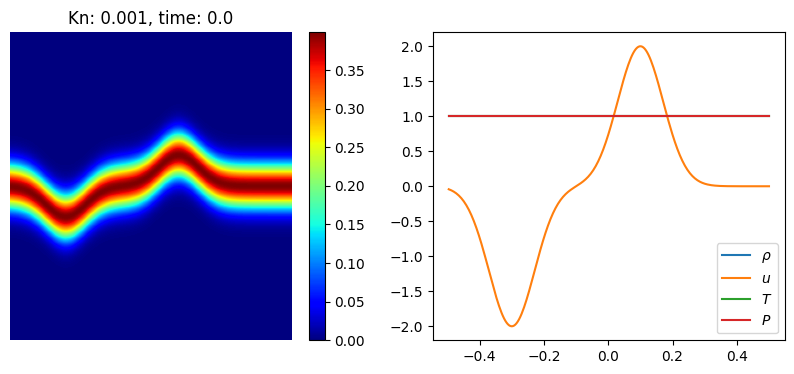

In [8]:
drawing(0)

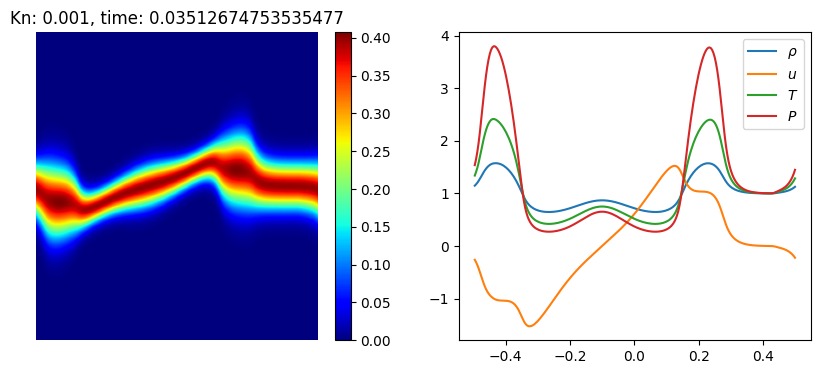

In [9]:
drawing(len(t)//2)

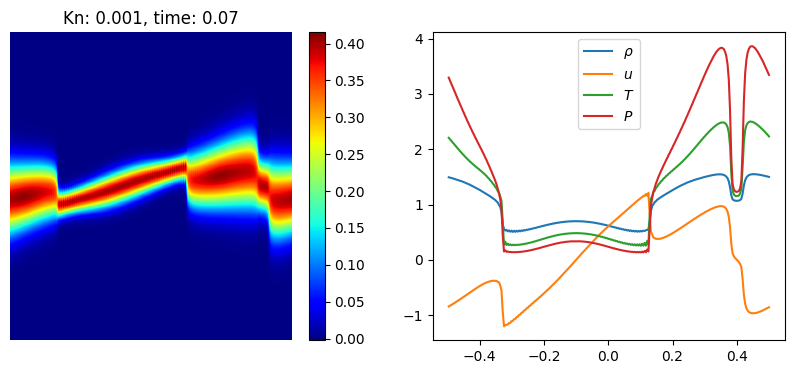

In [10]:
drawing(-1)

In [11]:
heaviside = lambda x: 0.5 * (1 + np.tanh(100 * x))
distance = lambda x: 0.25**2 - x**2
def rho0(x):
    return 0.125 + 0.875 * heaviside(distance(x))

def u0(x):
    return np.zeros(x.shape)

def temp0(x):
    return 0.8 + 0.2 * heaviside(distance(x))

rho0, u0, temp0 = rho0(x)[:,None], u0(x)[:,None], temp0(x)[:,None]

f0 = np.exp(- (v - u0)**2 / (2 * temp0)) * rho0 / np.sqrt(2 * np.pi * temp0)
f0hat = rfft2(f0).ravel()

solver = RK45(eqn, t0=0., y0=f0hat, t_bound=T)
t, fhat = [0.], [f0hat]

while solver.status == 'running':
    solver.step()
    t.append(solver.t)
    fhat.append(solver.y)

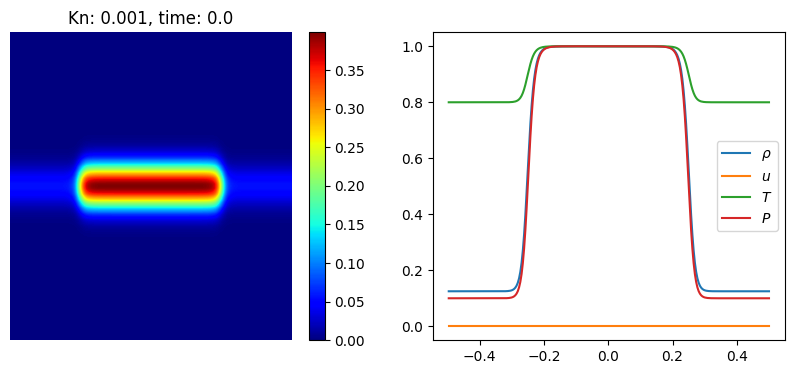

In [12]:
drawing(0)

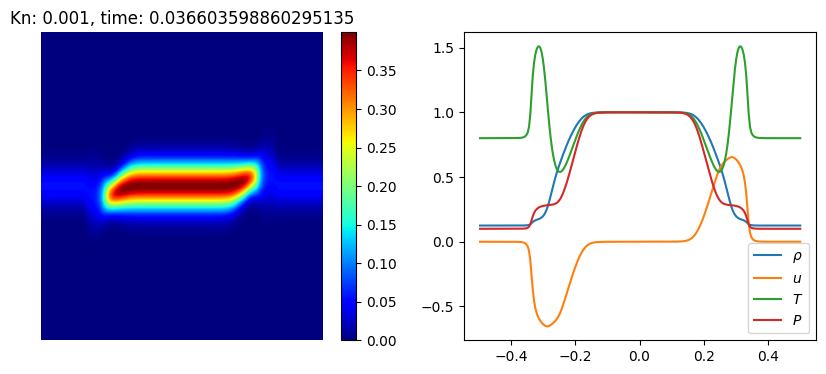

In [13]:
drawing(len(t)//2)


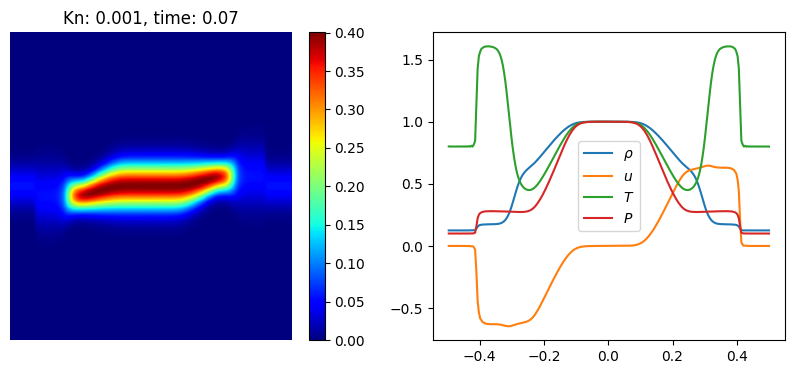

In [14]:
drawing(-1)

In [15]:
m0 = list(map(lambda x: irfft2(x.reshape(shape), N).sum() / Nv / Nx * 2 * 2 * V, fhat))
m1 = list(map(lambda x: (v * irfft2(x.reshape(shape), N)).sum() / Nv / Nx * 2 * 2 * V, fhat))
m2 = list(map(lambda x: (v**2 * irfft2(x.reshape(shape), N)).sum() / Nv / Nx * 2 * 2 * V, fhat))

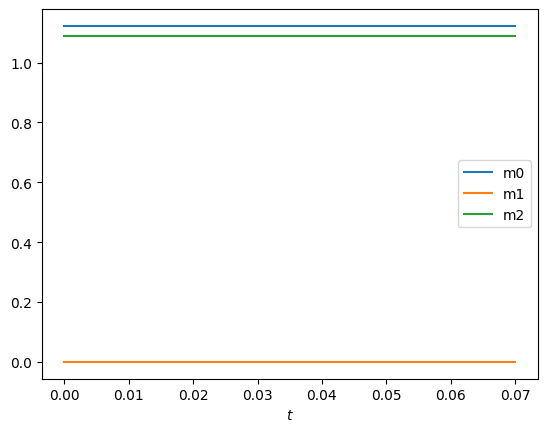

In [16]:
plt.plot(t, m0, label='m0')
plt.plot(t, m1, label='m1')
plt.plot(t, m2, label='m2')
plt.xlabel(r"$t$")
plt.legend()
plt.show()

In [17]:
def rho0(x):
    return 1 + 0.5 * np.sin(2*np.pi * x)

def u0(x):
    return np.zeros(x.shape)

def temp0(x):
    return 1 + 0.5 * np.sin(2*np.pi * x + 0.2)

rho0, u0, temp0 = rho0(x)[:,None], u0(x)[:,None], temp0(x)[:,None]

f0 = np.exp(- (v - u0)**2 / (2 * temp0)) * rho0 / np.sqrt(2 * np.pi * temp0)
f0hat = rfft2(f0).ravel()

solver = RK45(eqn, t0=0., y0=f0hat, t_bound=T)
t, fhat = [0.], [f0hat]

while solver.status == 'running':
    solver.step()
    t.append(solver.t)
    fhat.append(solver.y)

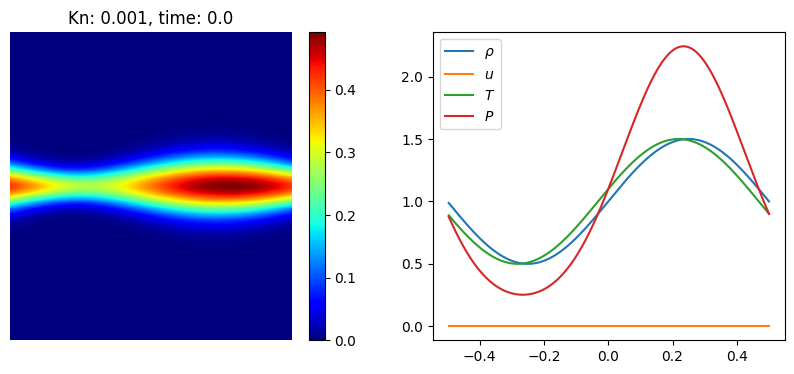

In [18]:
drawing(0)

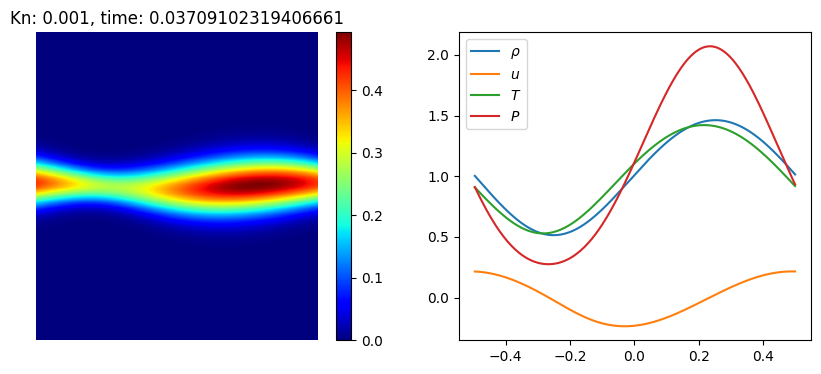

In [19]:
drawing(len(t)//2)

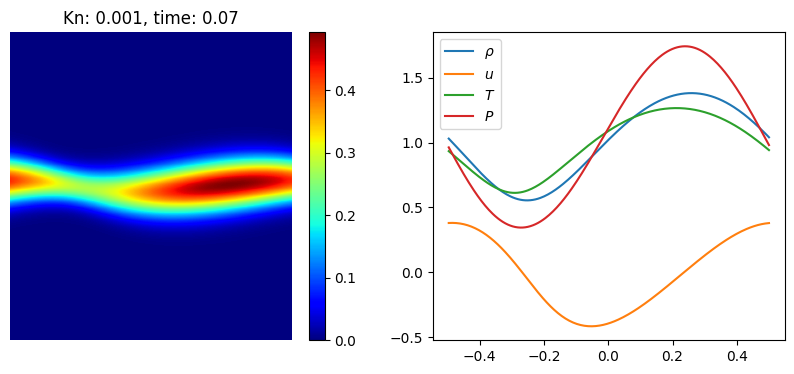

In [20]:
drawing(-1)